In [1]:
import tensorflow.keras as K

2021-07-27 17:36:41.116866: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
model = K.models.load_model('saved_models/DenseNet49-DeepSense-baseline-20210725-194831-baseline/DenseNet49-DeepSense-baseline-50.hdf5')

2021-07-27 17:36:43.355247: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-27 17:36:44.743173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA Tesla M40 computeCapability: 5.2
coreClock: 1.112GHz coreCount: 24 deviceMemorySize: 11.18GiB deviceMemoryBandwidth: 268.58GiB/s
2021-07-27 17:36:44.743979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA Tesla M40 computeCapability: 5.2
coreClock: 1.112GHz coreCount: 24 deviceMemorySize: 11.18GiB deviceMemoryBandwidth: 268.58GiB/s
2021-07-27 17:36:44.744020: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-27 17:36:44.777352: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
202

LISTDIR::::: ['ruifeng_by_date.json', '.ipynb_checkpoints', 'data_raw', 'enetv2', 'saved_models', 'enetv2.h5', 'data_split.ipynb', 'Untitled.ipynb', 'keras_impl.ipynb', 'data', 'keras_impl.py', 'DenseNet49-DeepSense-baseline', 'model', 'logs', 'densenet.py', 'EfficientNetB0-DeepSense-baseline.h5', 'train.py']
ENV::::::::: ./data
CUDA_VISIBLE::::::::: None
DEV::::::::: ['nvidia-modeset', 'nvidia-uvm-tools', 'i2c-6', 'i2c-5', 'nvidia1', 'i2c-4', 'i2c-3', 'kvm', 'nvidia0', 'nvidia-caps', 'nvidiactl', 'nvidia-uvm', 'vcsa2', 'vcs2', 'vcsa3', 'vcs3', 'vcsa5', 'vcs5', 'vcsa6', 'vcs6', 'vcsa4', 'vcs4', 'ipmi0', 'snd', 'vhost-vsock', 'vhost-net', 'uhid', 'vhci', 'vfio', 'userio', 'btrfs-control', 'cuse', 'log', 'mqueue', 'hugepages', 'initctl', 'shm', 'autofs', 'sdb1', 'disk', 'sda3', 'sda2', 'sda1', 'sdb', 'sda', 'sg1', 'bsg', 'sg0', 'ptp1', 'i2c-2', 'hidraw1', 'hidraw0', 'ptp0', 'i2c-1', 'fb0', 'i2c-0', 'dri', 'block', 'rtc', 'char', 'stderr', 'stdout', 'stdin', 'fd', 'core', 'pts', 'memory_b

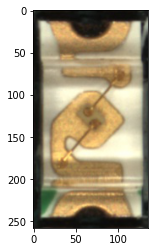

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
import tensorflow.keras as keras
from os.path import join as ospj
import os
from datetime import datetime

SWARM_LEARNING = os.getenv('SLNUM') is not None

print("LISTDIR:::::",os.listdir('.'))
print("ENV:::::::::",os.getenv('DATA_DIR', './data'))
print("CUDA_VISIBLE:::::::::",os.getenv('CUDA_VISIBLE_DEVICES'))
print("DEV:::::::::",os.listdir('/dev'))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        pass
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)



DATA_DIR=os.getenv('DATA_DIR', './data')
DATA_ROOT=ospj(DATA_DIR, 'ruifeng')
BATCH_SIZE=32





data = None
with open('ruifeng_by_date.json', 'r') as fp:
    data = json.load(fp)
print(data.keys())





print(data['img_size'])
print(data['label_index'])





img=plt.imread(ospj(DATA_ROOT, data['train']['pos'][0][0]))
print(img.shape)
plt.imshow(img)





def get_dataset(pos_list, neg_list, data_root='data', training=True, batch_size=BATCH_SIZE):
    def img_pre_proc(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, data['img_size'][:2])
        image = tf.cast(image, tf.float32)
        image = keras.applications.densenet.preprocess_input(image)
        # image = tf.image.per_image_standardization(image)
        return image

    def label_pre_proc(label):
        idx = 0 if label == data['label_index']['Ok'] else 1
        return tf.one_hot(idx, depth=2)
#        return 0 if label == data['label_index']['Ok'] else 1
    
    print('Total pos count:', len(pos_list))
    print('Total neg count:', len(neg_list))
    lst = pos_list + neg_list
    #print(len(lst), len(lst)%batch_size)
    img_lst, label_lst = zip(*lst)
    img_lst = [ospj(data_root, x) for x in img_lst]
    
    img_ds = tf.data.Dataset.from_tensor_slices(img_lst)
    img_ds = img_ds.map(img_pre_proc)

    label_ds = tf.data.Dataset.from_tensor_slices(list(label_lst))
    label_ds = label_ds.map(label_pre_proc)

    ds = tf.data.Dataset.zip((img_ds, label_ds))
    if training:
        ds = ds.shuffle(buffer_size=len(lst))
        ds = ds.repeat()
    ds = ds.batch(batch_size)
    # 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds





train_dataset = get_dataset(data_root=DATA_ROOT, pos_list=data['train']['pos'], neg_list=data['train']['neg'], training=True)
val_dataset = get_dataset(data_root=DATA_ROOT, pos_list=data['val']['pos'], neg_list=data['val']['neg'], training=False)
steps_per_epoch=np.math.ceil((len(data['train']['pos'])+len(data['train']['neg']))/BATCH_SIZE)

In [4]:
model_name = 'DenseNet49-DeepSense'

if SWARM_LEARNING:
    model_name += '-SL-{0}'.format(os.getenv('SLNUM'))
else:
    model_name += '-baseline'
    model.save(model_name)

2021-07-27 17:37:13.419507: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: DenseNet49-DeepSense-baseline/assets


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        *[keras.metrics.Recall(name='{0}-Recall'.format(x), class_id=x) for x in range(2)],
        *[keras.metrics.Precision(name='{0}-Precision'.format(x), class_id=x) for x in range(2)]]
)

In [5]:
current_name = model_name + '-' + datetime.now().strftime("%Y%m%d-%H%M%S")
swSyncInterval = steps_per_epoch * 5
min_peers = 3
current_name += '-baseline'


try:
    os.mkdir('./saved_models')
    os.mkdir('./saved_models/' + current_name)
except:
    pass

callbacks=[
    keras.callbacks.ModelCheckpoint('saved_models/' + current_name + '/' + model_name + '-{epoch:02d}.hdf5'),
    keras.callbacks.TensorBoard(
        log_dir="logs/profile/" + current_name,
        profile_batch=3
    )
]

# model.save('enetv2.h5') 

2021-07-27 17:38:04.879280: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-27 17:38:04.879318: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-27 17:38:04.889921: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 2 GPUs
2021-07-27 17:38:04.912852: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so.11.2
2021-07-27 17:38:05.345980: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-27 17:38:05.366399: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


In [ ]:
max_epochs = 100

model.fit(
    train_dataset,
    epochs=max_epochs,
    validation_data=val_dataset,
    validation_freq=1,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    initial_epoch=50
)

Epoch 51/100


2021-07-27 17:38:50.236941: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-27 17:38:50.297592: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299890000 Hz
2021-07-27 17:39:01.396174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35446 of 45248
2021-07-27 17:39:04.592795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2021-07-27 17:39:04.673954: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-27 17:39:05.747900: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-07-27 17:39:08.852150: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-27 17:39:09.854229: I tensorflow/stream_executor/platform/default/ds

   2/1414 [..............................] - ETA: 12:21 - loss: 1.2939e-04 - accuracy: 1.0000 - 0-Recall: 1.0000 - 1-Recall: 1.0000 - 0-Precision: 1.0000 - 1-Precision: 1.0000  

2021-07-27 17:39:12.564524: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-27 17:39:12.564568: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


   3/1414 [..............................] - ETA: 16:22 - loss: 9.8194e-04 - accuracy: 1.0000 - 0-Recall: 1.0000 - 1-Recall: 1.0000 - 0-Precision: 1.0000 - 1-Precision: 1.0000

2021-07-27 17:39:13.433858: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-27 17:39:13.448234: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2021-07-27 17:39:13.547961: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1266 callback api events and 1259 activity events. 
2021-07-27 17:39:13.587982: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-27 17:39:13.639173: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/profile/DenseNet49-DeepSense-baseline-20210727-173804-baseline/train/plugins/profile/2021_07_27_17_39_13
2021-07-27 17:39:13.666754: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/profile/DenseNet49-DeepSense-baseline-20210727-173804-baseline/train/plugins/profile/2021_07_27_17_39_13/GPU-SERVER.trace.json.

1414/1414 [==============================] - 224s 141ms/step - loss: 0.0042 - accuracy: 0.9985 - 0-Recall: 0.9992 - 1-Recall: 0.9956 - 0-Precision: 0.9989 - 1-Precision: 0.9969 - val_loss: 0.7358 - val_accuracy: 0.8826 - val_0-Recall: 0.8831 - val_1-Recall: 0.8802 - val_0-Precision: 0.9709 - val_1-Precision: 0.6244
Epoch 52/100
1414/1414 [==============================] - 196s 138ms/step - loss: 0.0045 - accuracy: 0.9986 - 0-Recall: 0.9993 - 1-Recall: 0.9959 - 0-Precision: 0.9989 - 1-Precision: 0.9974 - val_loss: 1.2659 - val_accuracy: 0.8059 - val_0-Recall: 0.7791 - val_1-Recall: 0.9272 - val_0-Precision: 0.9798 - val_1-Precision: 0.4810
Epoch 53/100
1414/1414 [==============================] - 195s 138ms/step - loss: 0.0022 - accuracy: 0.9994 - 0-Recall: 0.9997 - 1-Recall: 0.9984 - 0-Precision: 0.9996 - 1-Precision: 0.9988 - val_loss: 0.8467 - val_accuracy: 0.8676 - val_0-Recall: 0.8598 - val_1-Recall: 0.9031 - val_0-Precision: 0.9757 - val_1-Precision: 0.5872
Epoch 54/100
1414/1414 